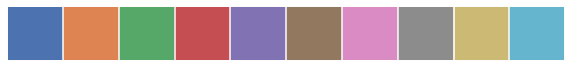

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set('talk')
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'large',
          'figure.figsize': (16, 9),
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
plt.rcParams.update(params)
import json
from pandas.io.json import json_normalize
current_palette = sns.color_palette()
sns.palplot(current_palette)

In [224]:
labels = ['ResNet', 'DenseNet', 'B-ResNet', 'B-DenseNet', 'MSDNet']
models = ['resnet', 'densenet', 'b-resnet', 'b-densenet', 'msdnet']
platforms = ['gpu', 'jetson', 'nuc']

In [225]:
results = {
    platform : {
        model : pd.read_json(platform + '_local_'  + model + '.json') for model in models 
    } for platform in platforms
}

In [226]:
results['nuc']['b-densenet'] = pd.read_json('nuc' + '_local_'  + 'b-densenet' + '2' + '.json')

In [227]:
results['jetson']['b-densenet'] = pd.read_json('jetson' + '_local_'  + 'b-densenet' + '2' + '.json')

In [215]:
results['jetson']['b-densenet'].mean()

KeyboardInterrupt: 

In [228]:
stats = {
    platform : {
        model : {} for model in models
    } for platform in platforms
    
}
for platform in platforms:
    for exits, model in zip([1,1,4,4,5], models):
        stats[platform][model]['mean'] = np.cumsum(np.array(results[platform][model][exits:].groupby('exit').time.mean())).tolist()
        stats[platform][model]['std']  = np.cumsum(np.array(results[platform][model][exits:].groupby('exit').time.std())).tolist()
        stats[platform][model]['min']  = np.cumsum(np.array(results[platform][model][exits:].groupby('exit').time.min())).tolist()
        stats[platform][model]['max']  = np.cumsum(np.array(results[platform][model][exits:].groupby('exit').time.max())).tolist()

In [229]:
pd.DataFrame(stats['jetson']['b-densenet'])

,mean,std,min,max
0,11.053042,0.481067,10.515266,17.308576
1,30.262047,2.022229,23.751709,47.538935
2,55.327435,3.220744,48.096324,87.812975
3,72.402664,3.890378,64.767239,120.286752


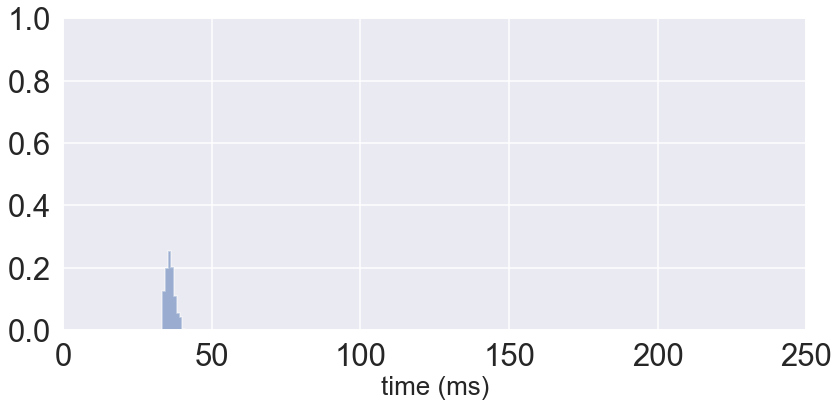

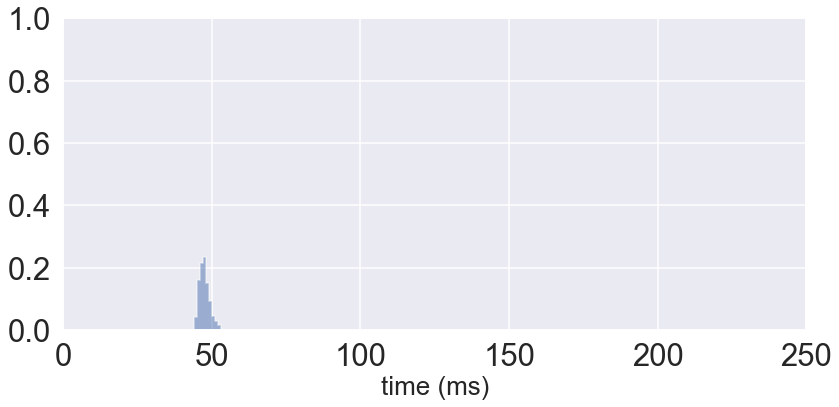

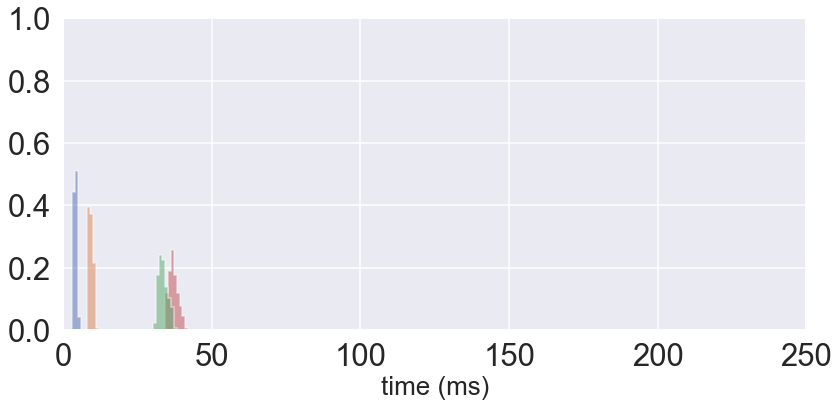

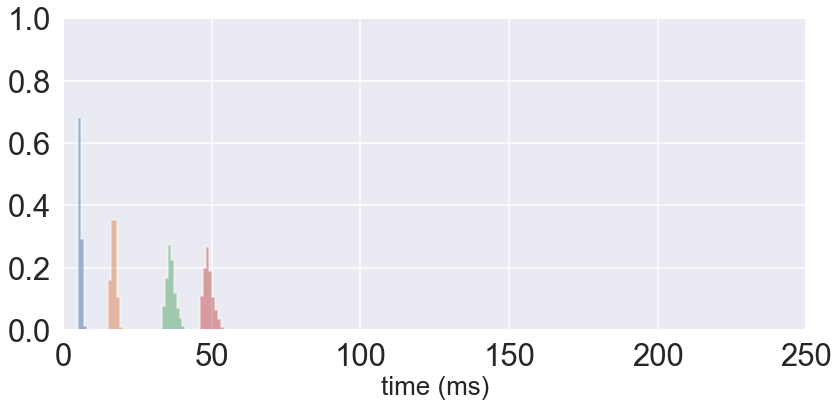

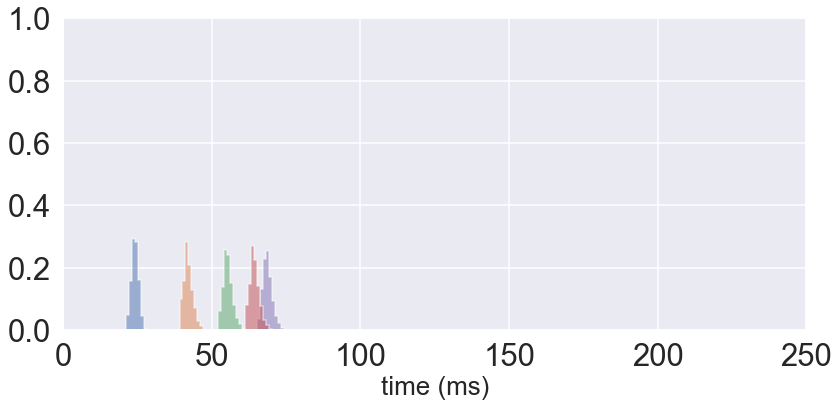

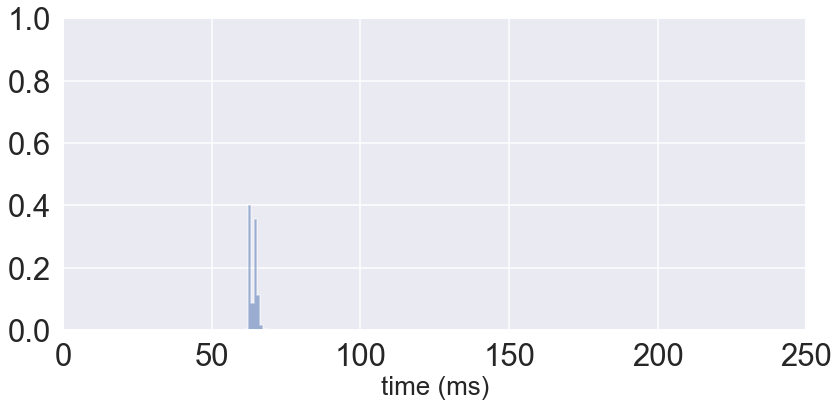

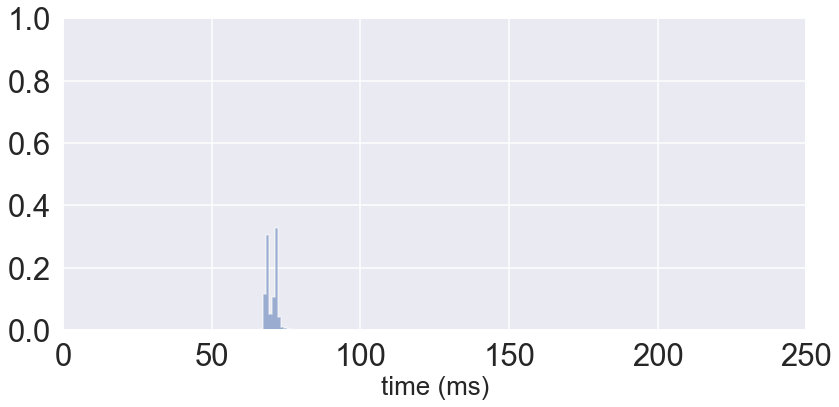

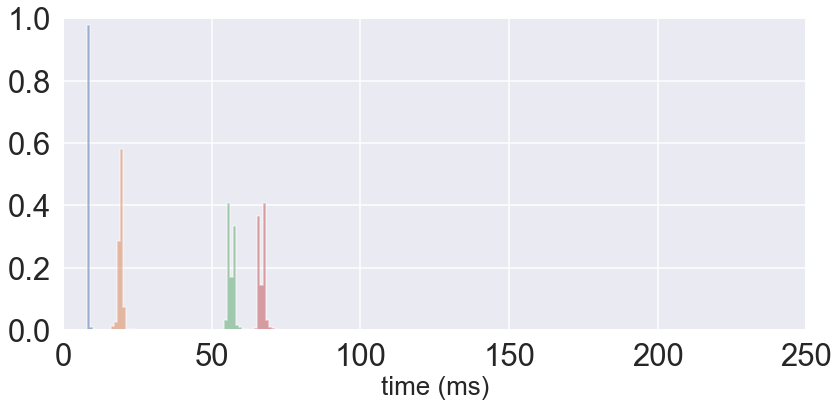

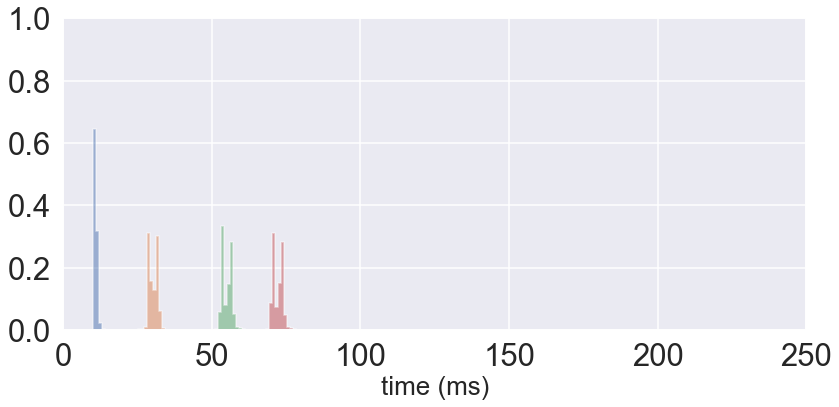

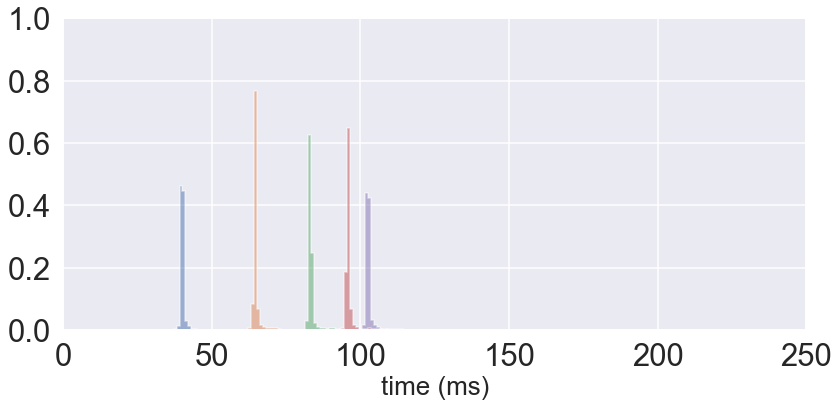

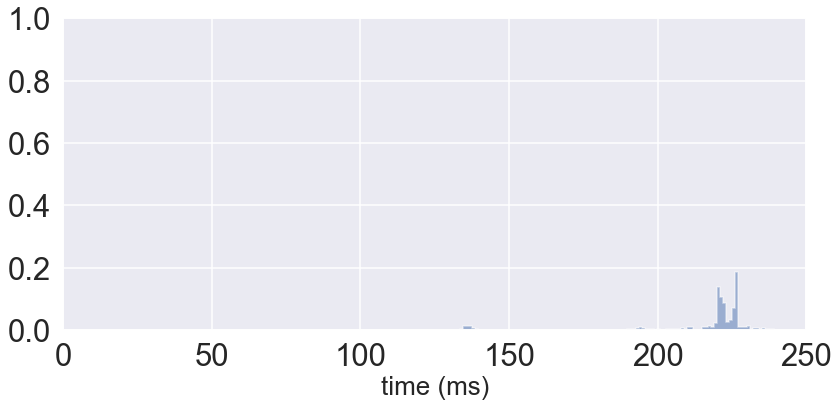

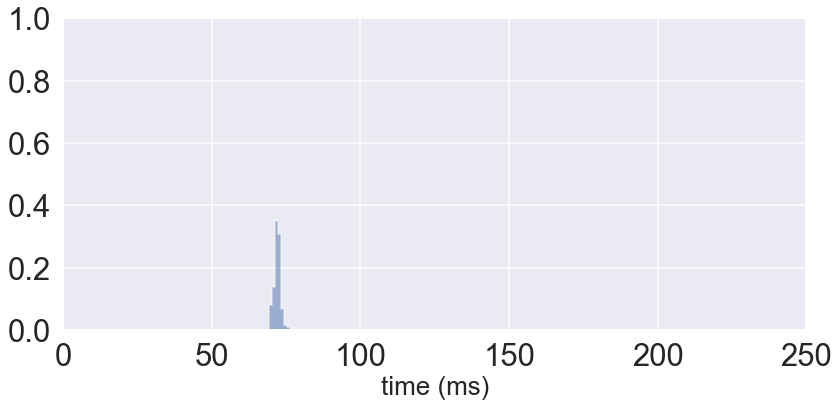

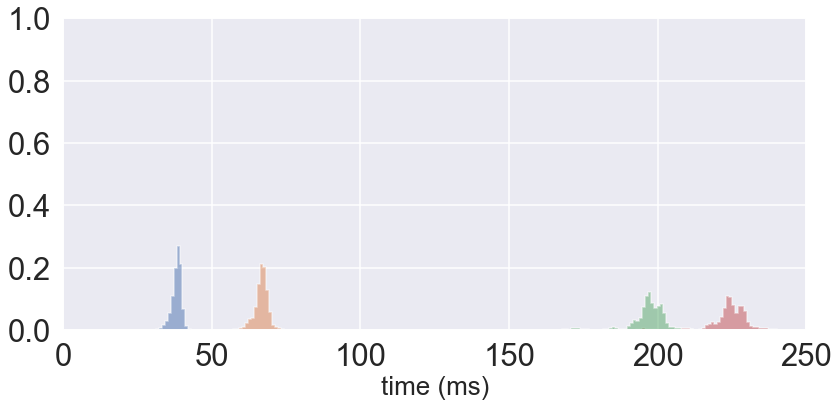

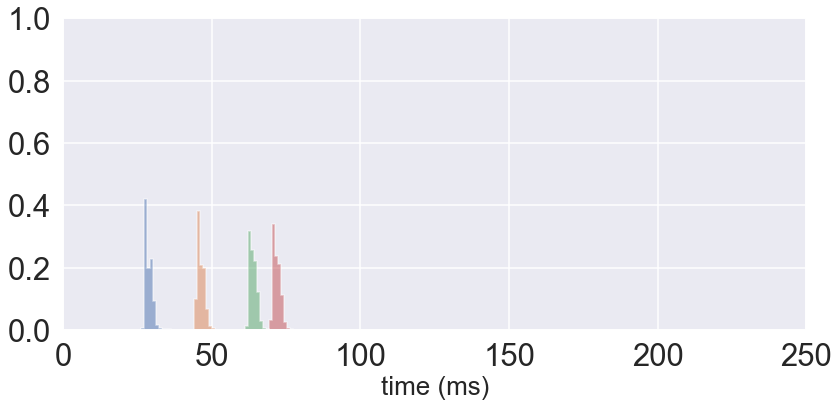

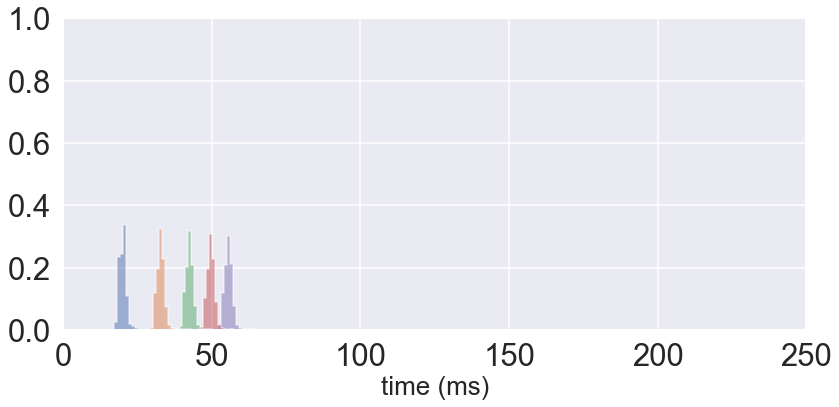

In [230]:
for platform in platforms:
    for model in models:
        fig, axes = plt.subplots(1,1, figsize=(12,6))
        axes.set_xlim([0,250])
        axes.set_ylim([0,1])
        bins = np.linspace(0,250,250)
        
        if model == 'b-resnet' or model == 'b-densenet':
            exits = 4
        elif model == 'msdnet':
            exits = 5
        else:
            exits = 1
            
        time_data = np.zeros((exits,5000))
        for sample, (exit, data) in enumerate(results[platform][model].groupby('exit')):
            time_data[exit]= data.time
        time_data = np.cumsum(time_data, axis=0)
        axes.hist(time_data.T, bins, density=True, histtype='stepfilled',alpha=0.5)

        axes.set_xlabel('time (ms)', fontsize='x-large')
        axes.tick_params(labelsize='xx-large')
        #axes.set_yticks(np.arange(0,1.1,0.25))
        fig.tight_layout()

        plt.savefig(platform + '_' + model + '_inference_time_distribution.png')

In [202]:
model_conf = {
    model : { threshold : { 'exit-{}'.format(i): {} for i in range(5) } for threshold in np.around(np.arange(0.1,1,0.1),2)} for model in models[2:]
}
for model in models[2:]:
    # should be shanges to gpu
    
    for threshold in np.around(np.arange(0.1,1,0.1),2):
        passed = [None]
        for i, data in results['jetson'][model].groupby('exit'):
            scores = np.array(data['confidence'].tolist())
            top1 = scores[:,0]
            corrects = np.array(data['correct'].tolist())
            

        
            if passed[0] == None:
                passed = top1 > threshold
                cp = [elem for i, elem in enumerate(corrects) if passed[i]==True]
                not_exited =  np.count_nonzero(passed == False)
            else:
                already_passed = np.zeros(5000)
                for n, e in enumerate(passed):
                    already_passed[n] = e
                passed = top1 > threshold
                #print(len(passed), len(already_passed), len(corrects))
                #passed = [elem for i, elem in enumerate(passed) if already_passed[i]==True]
                cp = [elem for i, elem in enumerate(corrects) if passed[i]==False]
                not_exited =  np.count_nonzero(already_passed == False)
                #print(passed)

            #print(len(passed))
            
            #print(not_exited)
            
            if len(cp) != 0:
                unique, what = np.unique(cp, return_counts=True)
                if len(what) == 1:
                    if unique[0] == False:
                        model_conf[model][threshold]['exit-{}'.format(i)]['incorrect'] = what[0]
                    else:
                        model_conf[model][threshold]['exit-{}'.format(i)]['correct'] = what[0]
                else:
                    model_conf[model][threshold]['exit-{}'.format(i)]['correct'] = what[0]
                    model_conf[model][threshold]['exit-{}'.format(i)]['incorrect'] = what[1]
            else:
                model_conf[model][threshold]['exit-{}'.format(i)]['correct'] = 0
                model_conf[model][threshold]['exit-{}'.format(i)]['incorrect'] = 0
            model_conf[model][threshold]['exit-{}'.format(i)]['not exited'] = not_exited
            model_conf[model][threshold]['exit-{}'.format(i)]['total'] = (correct + incorrect)

            if model == 'msdnet' and i ==5:
                

In [203]:
model_conf

{'b-resnet': {0.1: {'exit-0': {'correct': 2463,
    'incorrect': 2434,
    'not exited': 103,
    'total': 4897},
   'exit-1': {'incorrect': 7, 'not exited': 103, 'total': 4897},
   'exit-2': {'correct': 0, 'incorrect': 0, 'not exited': 7, 'total': 4897},
   'exit-3': {'correct': 0, 'incorrect': 0, 'not exited': 0, 'total': 4897},
   'exit-4': {}},
  0.2: {'exit-0': {'correct': 1763,
    'incorrect': 2276,
    'not exited': 961,
    'total': 4897},
   'exit-1': {'correct': 197,
    'incorrect': 35,
    'not exited': 961,
    'total': 4897},
   'exit-2': {'incorrect': 13, 'not exited': 232, 'total': 4897},
   'exit-3': {'incorrect': 1, 'not exited': 13, 'total': 4897},
   'exit-4': {}},
  0.3: {'exit-0': {'correct': 1109,
    'incorrect': 1978,
    'not exited': 1913,
    'total': 4897},
   'exit-1': {'correct': 487,
    'incorrect': 141,
    'not exited': 1913,
    'total': 4897},
   'exit-2': {'correct': 39, 'incorrect': 6, 'not exited': 628, 'total': 4897},
   'exit-3': {'correct': 1

KeyError: 'correct'

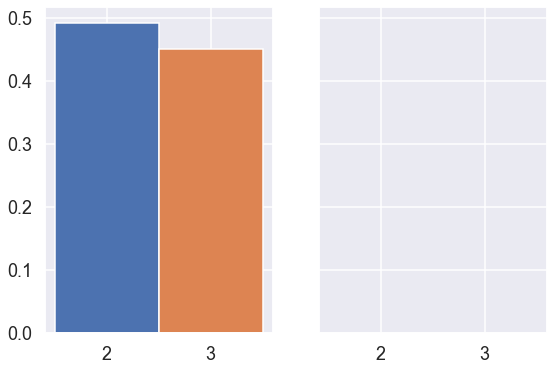

In [204]:
width=1
x=2
n = np.arange(x)

for threshold in np.around(np.arange(0.1,1,0.1),2):
    fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(9,6))
    
    # Add some extra space for the second axis at the bottom
    #fig.subplots_adjust(bottom=0.1)

    #ax.set_title('Threshold {:0.1f}'.format(data[0]))
    xx = x + width/2
    
        
        #axes.bar(4+x+width*index_offset, incorrect[exit_n], width=width)
    for exit_n in range(4):
        #print(incorrect, correct)
        axes[0].bar(exit_n*4 + x , model_conf['b-resnet'][threshold]['exit-{}'.format(exit_n)]['correct']/5000, width=width, color=current_palette[0])
        axes[0].bar(exit_n*4 + x+width, model_conf['b-densenet'][threshold]['exit-{}'.format(exit_n)]['correct']/5000, width=width, color=current_palette[1])
        
    for exit_n in range(5):
        axes[0].bar(exit_n*4 + x+width*2, model_conf['msdnet'][threshold]['exit-{}'.format(exit_n)]['correct']/5000, width=width, color=current_palette[2])
        
    for exit_n in range(4):
        axes[1].bar(exit_n*4 + x , model_conf['b-resnet'][threshold]['exit-{}'.format(exit_n)]['incorrect']/5000, width=width, color=current_palette[0])
        axes[1].bar(exit_n*4 + x+width, model_conf['b-densenet'][threshold]['exit-{}'.format(exit_n)]['incorrect']/5000, width=width, color=current_palette[1])
    
    for exit_n in range(5):
        axes[1].bar(exit_n*4 + x+width*2, model_conf['msdnet'][threshold]['exit-{}'.format(exit_n)]['incorrect']/5000, width=width, color=current_palette[2])

    
    axes[0].set_xlabel('Exit-#', fontsize='large')
    axes[0].set_ylabel('frequency', fontsize='x-large') 
    axes[0].set_title('correct', fontsize='x-large')
    axes[1].set_xlabel('Exit-#', fontsize='large')
    axes[1].set_title('incorrect', fontsize='x-large')
    for ax in axes:
        ax.set_xticks(np.arange(3,20,4))
        ax.set_ylim([0,0.9])
        ax.set_xticklabels(['{}'.format(x) for x in range(5)], fontsize='large')

        ax.xaxis.grid(None)
        
    for tick in axes[0].yaxis.get_major_ticks():
                tick.label.set_fontsize('large') 

    fig.tight_layout()
    
    #fig.suptitle('$T = {:.1f}$'.format(i))

    fig.tight_layout()
    fig.subplots_adjust(top=0.9)

    plt.savefig('model_comparison_confidence{}.png'.format(n+1))
#fig.legend(['B-ResNet', 'B-DenseNet', 'MSDNet'], ncol=3, loc='upper center')